# Hard Examples Analysis & Dataset Cleaning

This notebook analyzes hard training examples (highest-loss samples) and helps clean the training dataset for the AN2DL image classification challenge.

In [1]:
# Cell 2: Imports and global paths
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

BASE_DIR = os.path.abspath(os.path.join(".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
TRAIN_CSV_PATH = os.path.join(DATA_DIR, "train_labels.csv")
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_data")
HARD_EXAMPLES_DIR = os.path.join(BASE_DIR, "hard_examples")

## 1. Load Raw Training Dataset

In [2]:
# Cell 4: Load training labels and basic stats
df_train = pd.read_csv(TRAIN_CSV_PATH)
print(f"Total training samples: {len(df_train)}")
print("\nLabel distribution:")
print(df_train['label'].value_counts())

df_train.head()

Total training samples: 1412

Label distribution:
label
Luminal B          445
Luminal A          414
HER2(+)            397
Triple negative    156
Name: count, dtype: int64


sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal A
2  img_0002.png        Luminal A
3  img_0003.png        Luminal B
4  img_0004.png          HER2(+)

## 2. Load Hard Examples from Training

Here we load the per-epoch hard example CSVs generated during training and aggregate them.

In [3]:
# Cell 6: Load and aggregate hard_examples CSVs
hard_example_files = sorted(glob.glob(os.path.join(HARD_EXAMPLES_DIR, "hard_examples_epoch_*.csv")))
print(f"Found {len(hard_example_files)} hard_examples files")

hard_dfs = []
for fp in hard_example_files:
    df_h = pd.read_csv(fp)
    df_h["source_file"] = os.path.basename(fp)
    hard_dfs.append(df_h)

if hard_dfs:
    df_hard = pd.concat(hard_dfs, ignore_index=True)
else:
    df_hard = pd.DataFrame(columns=["sample_index", "loss", "epoch", "source_file"])

print(f"Total hard-example records: {len(df_hard)}")
df_hard.head()

Found 21 hard_examples files
Total hard-example records: 1050


sample_index      loss  epoch                source_file
0  img_0307.png  5.088315      0  hard_examples_epoch_0.csv
1  img_0704.png  4.937423      0  hard_examples_epoch_0.csv
2  img_0102.png  4.786507      0  hard_examples_epoch_0.csv
3  img_0909.png  3.857247      0  hard_examples_epoch_0.csv
4  img_0644.png  3.770507      0  hard_examples_epoch_0.csv

## 3. Compute Difficulty Scores and Candidate Set

We aggregate per-sample losses across epochs and compute summary difficulty statistics.

In [4]:
# Cell 8: Aggregate difficulty per sample
if len(df_hard) > 0:
    agg = df_hard.groupby("sample_index").agg(
        mean_loss=("loss", "mean"),
        max_loss=("loss", "max"),
        count=("loss", "count"),
    ).reset_index()

    # Difficulty score: we can use max_loss as primary
    agg["difficulty_score"] = agg["max_loss"]

    # Join with training labels
    df_hard_join = agg.merge(df_train, on="sample_index", how="left")

    print("Top 10 hardest examples:")
    display(df_hard_join.sort_values("difficulty_score", ascending=False).head(10))
else:
    df_hard_join = pd.DataFrame()
    print("No hard examples loaded.")

Top 10 hardest examples:


sample_index  mean_loss  max_loss  count  difficulty_score  \
111  img_0276.png   4.985948  7.350419      2          7.350419   
349  img_0883.png   5.234468  6.845459      2          6.845459   
434  img_1129.png   3.720231  6.178605      3          6.178605   
526  img_1358.png   6.155858  6.155858      1          6.155858   
443  img_1147.png   6.010890  6.146505      2          6.146505   
364  img_0921.png   3.805934  5.895981      7          5.895981   
220  img_0550.png   2.843898  5.830877      4          5.830877   
215  img_0539.png   3.439138  5.715304      7          5.715304   
418  img_1087.png   5.645982  5.645982      1          5.645982   
99   img_0242.png   3.207754  5.606791      5          5.606791   

               label  
111  Triple negative  
349          HER2(+)  
434          HER2(+)  
526        Luminal B  
443        Luminal A  
364        Luminal A  
220        Luminal A  
215  Triple negative  
418        Luminal B  
99   Triple negative

## 4. Visual Inspection of Hard Examples

Utility functions to visualize the hardest examples (image + label + stats) and manually inspect potential mislabels.

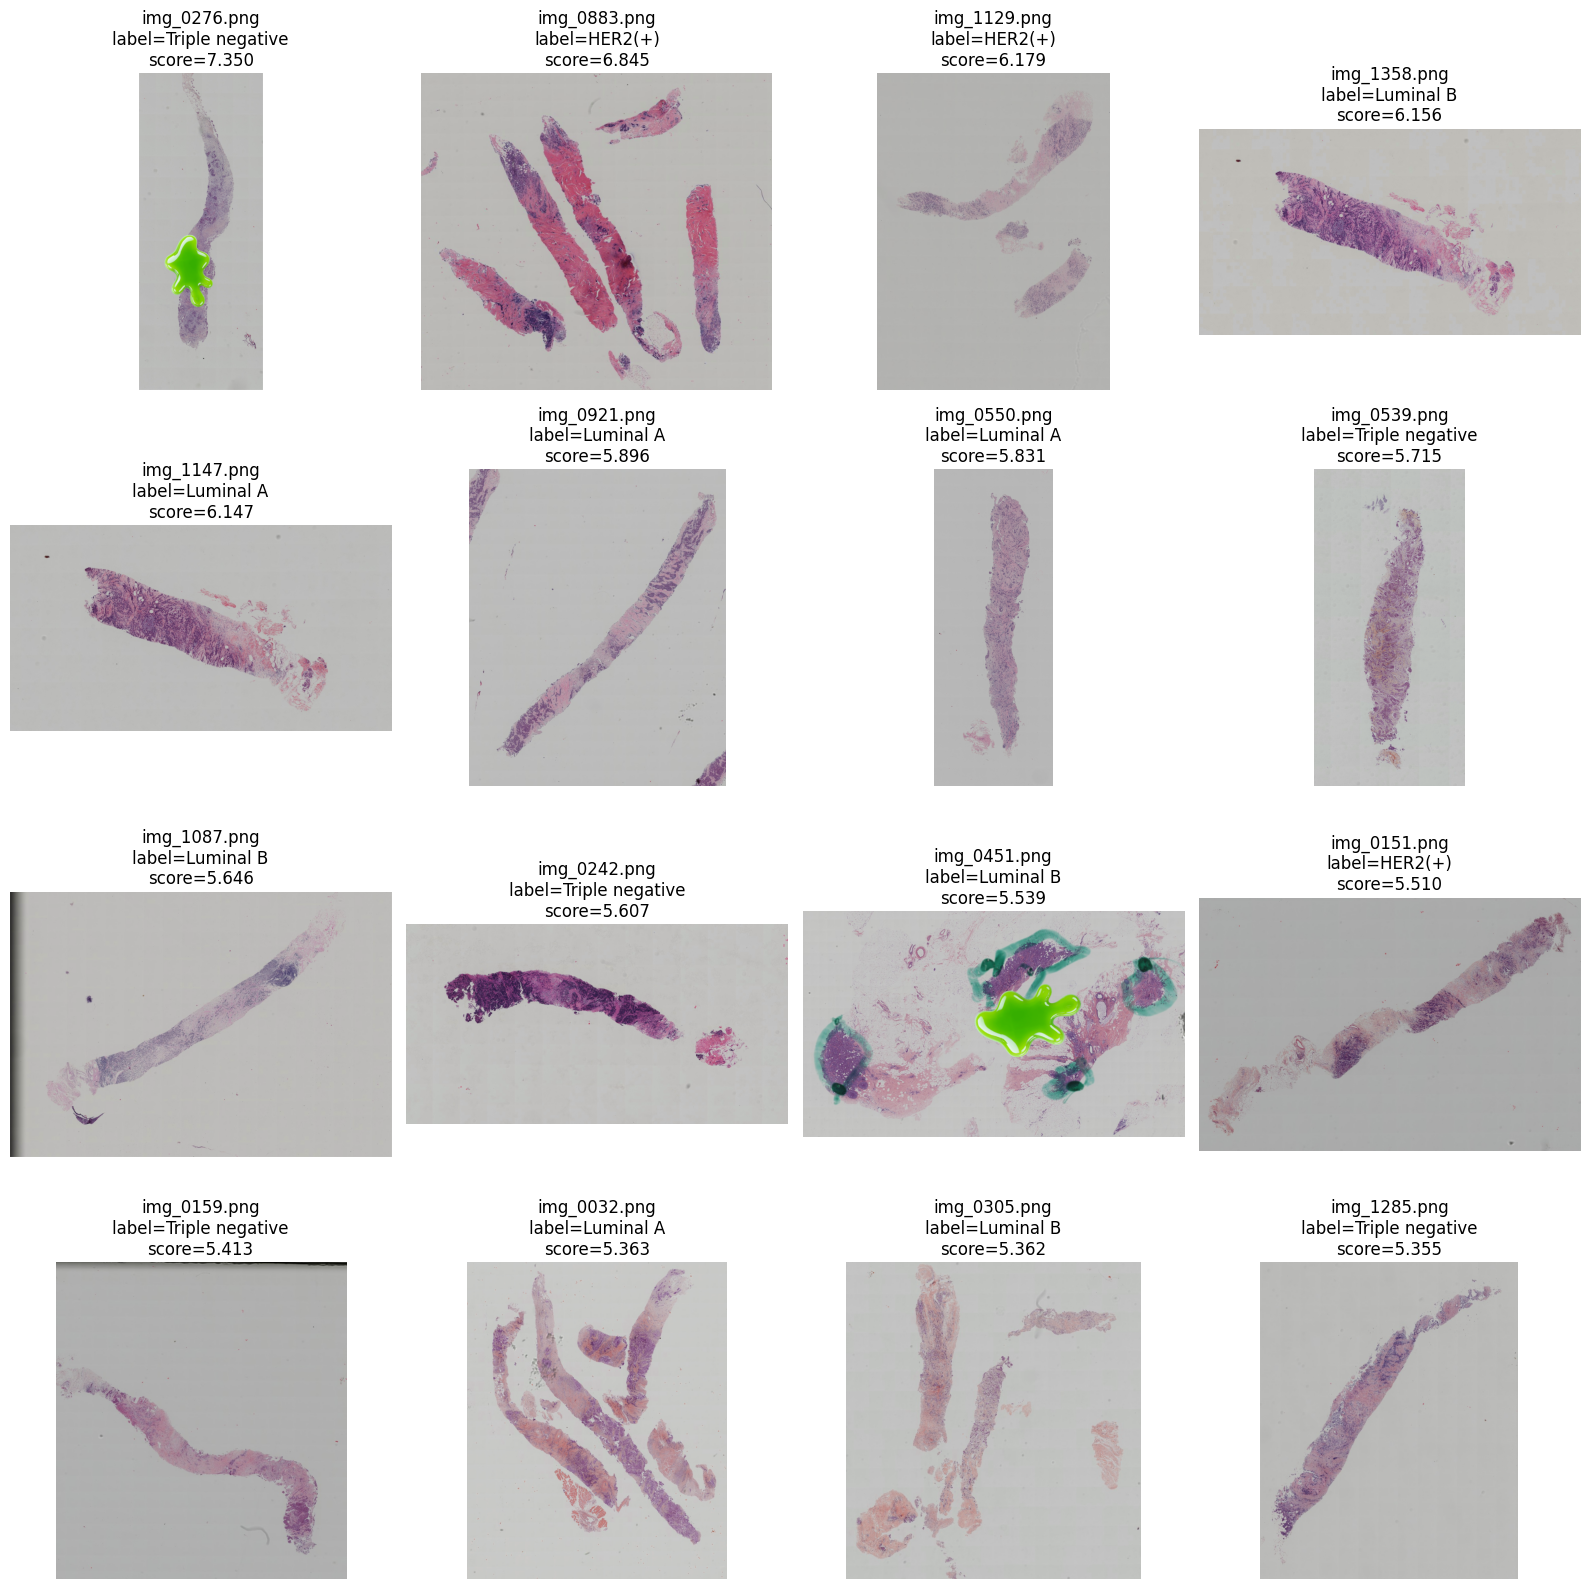

In [5]:
# Cell 10: Helper to show a grid of hard examples

def show_hard_examples(df_candidates, n=12, n_cols=4):
    if df_candidates.empty:
        print("No candidates to show.")
        return

    subset = df_candidates.sort_values("difficulty_score", ascending=False).head(n)
    n_rows = int(np.ceil(len(subset) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, subset.iterrows()):
        sample_index = row["sample_index"]
        img_path = os.path.join(TRAIN_IMG_DIR, sample_index)
        if not os.path.exists(img_path):
            ax.set_title(f"Missing: {sample_index}")
            ax.axis("off")
            continue
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"{sample_index}\nlabel={row['label']}\nscore={row['difficulty_score']:.3f}")
        ax.axis("off")

    # Hide unused axes
    for i in range(len(subset), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Example: visualize top-16 hardest examples
if not df_hard_join.empty:
    show_hard_examples(df_hard_join, n=16, n_cols=4)

## 5. Define Simple Cleaning Heuristics

We define heuristic rules to mark suspicious examples (likely mislabels or very ambiguous cases).

In [10]:
# Cell 12: Mark suspicious examples based on difficulty thresholds

# Example heuristic: mark samples in the top X% of difficulty as suspicious
SUSPICIOUS_TOP_PERCENT = 0.05  # top 1%

if not df_hard_join.empty:
    threshold = np.quantile(df_hard_join["difficulty_score"], 1.0 - SUSPICIOUS_TOP_PERCENT)
    df_hard_join["is_suspicious"] = df_hard_join["difficulty_score"] >= threshold
    print(f"Difficulty threshold for suspicious examples: {threshold:.4f}")
    print(df_hard_join["is_suspicious"].value_counts())
else:
    df_hard_join["is_suspicious"] = False

# Merge the suspicious flag back into the full training set
if not df_hard_join.empty:
    df_train_merged = df_train.merge(
        df_hard_join[["sample_index", "difficulty_score", "is_suspicious"]],
        on="sample_index",
        how="left",
    )
    df_train_merged["difficulty_score"] = df_train_merged["difficulty_score"].fillna(0.0)
    df_train_merged["is_suspicious"] = df_train_merged["is_suspicious"].fillna(False)
else:
    df_train_merged = df_train.copy()
    df_train_merged["difficulty_score"] = 0.0
    df_train_merged["is_suspicious"] = False

print("Suspicious vs non-suspicious counts:")
print(df_train_merged["is_suspicious"].value_counts())

df_train_merged.head()

Difficulty threshold for suspicious examples: 4.8348
is_suspicious
False    518
True      28
Name: count, dtype: int64
Suspicious vs non-suspicious counts:
is_suspicious
False    1384
True       28
Name: count, dtype: int64


/var/folders/tj/0mk4td753wdf74lwb26db8lc0000gn/T/ipykernel_80215/2523686309.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_merged["is_suspicious"] = df_train_merged["is_suspicious"].fillna(False)


sample_index            label  difficulty_score  is_suspicious
0  img_0000.png  Triple negative          2.831837          False
1  img_0001.png        Luminal A          0.000000          False
2  img_0002.png        Luminal A          0.000000          False
3  img_0003.png        Luminal B          0.000000          False
4  img_0004.png          HER2(+)          0.000000          False

## 6. Apply Cleaning and Build Cleaned Dataset

Here we decide what to do with suspicious examples (e.g., drop them) and create a cleaned training CSV.

In [11]:
# Cell 14: Drop suspicious examples to create cleaned dataset

# For now, we simply drop all suspicious examples.
# You can manually inspect and adjust this policy as needed.

df_cleaned = df_train_merged[~df_train_merged["is_suspicious"]].copy()

print(f"Original size: {len(df_train_merged)}")
print(f"Cleaned size: {len(df_cleaned)}")
print(f"Removed: {len(df_train_merged) - len(df_cleaned)} examples ({(len(df_train_merged) - len(df_cleaned)) / len(df_train_merged) * 100:.2f}% of data)")

df_cleaned.head()

Original size: 1412
Cleaned size: 1384
Removed: 28 examples (1.98% of data)


sample_index            label  difficulty_score  is_suspicious
0  img_0000.png  Triple negative          2.831837          False
1  img_0001.png        Luminal A          0.000000          False
2  img_0002.png        Luminal A          0.000000          False
3  img_0003.png        Luminal B          0.000000          False
4  img_0004.png          HER2(+)          0.000000          False

## 7. (Optional) Compare Training Before/After Cleaning

You can retrain your model using `train_effnet_mask.py` with `--train-csv` pointing to the cleaned CSV and compare metrics.

## 8. Export Cleaned Dataset

Save the cleaned dataset for reuse in training scripts.

In [12]:
# Cell 17: Save cleaned dataset to disk

OUTPUT_CSV_PATH = os.path.join(DATA_DIR, "train_labels_cleaned.csv")

# Keep only the original columns for training
cols_to_keep = [c for c in df_cleaned.columns if c in ["sample_index", "label"]]
df_to_save = df_cleaned[cols_to_keep].copy()

df_to_save.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Saved cleaned training labels to: {OUTPUT_CSV_PATH}")

# Quick sanity check
pd.read_csv(OUTPUT_CSV_PATH).head()

Saved cleaned training labels to: /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/data/train_labels_cleaned.csv


sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal A
2  img_0002.png        Luminal A
3  img_0003.png        Luminal B
4  img_0004.png          HER2(+)

Total removed (suspicious) samples: 28


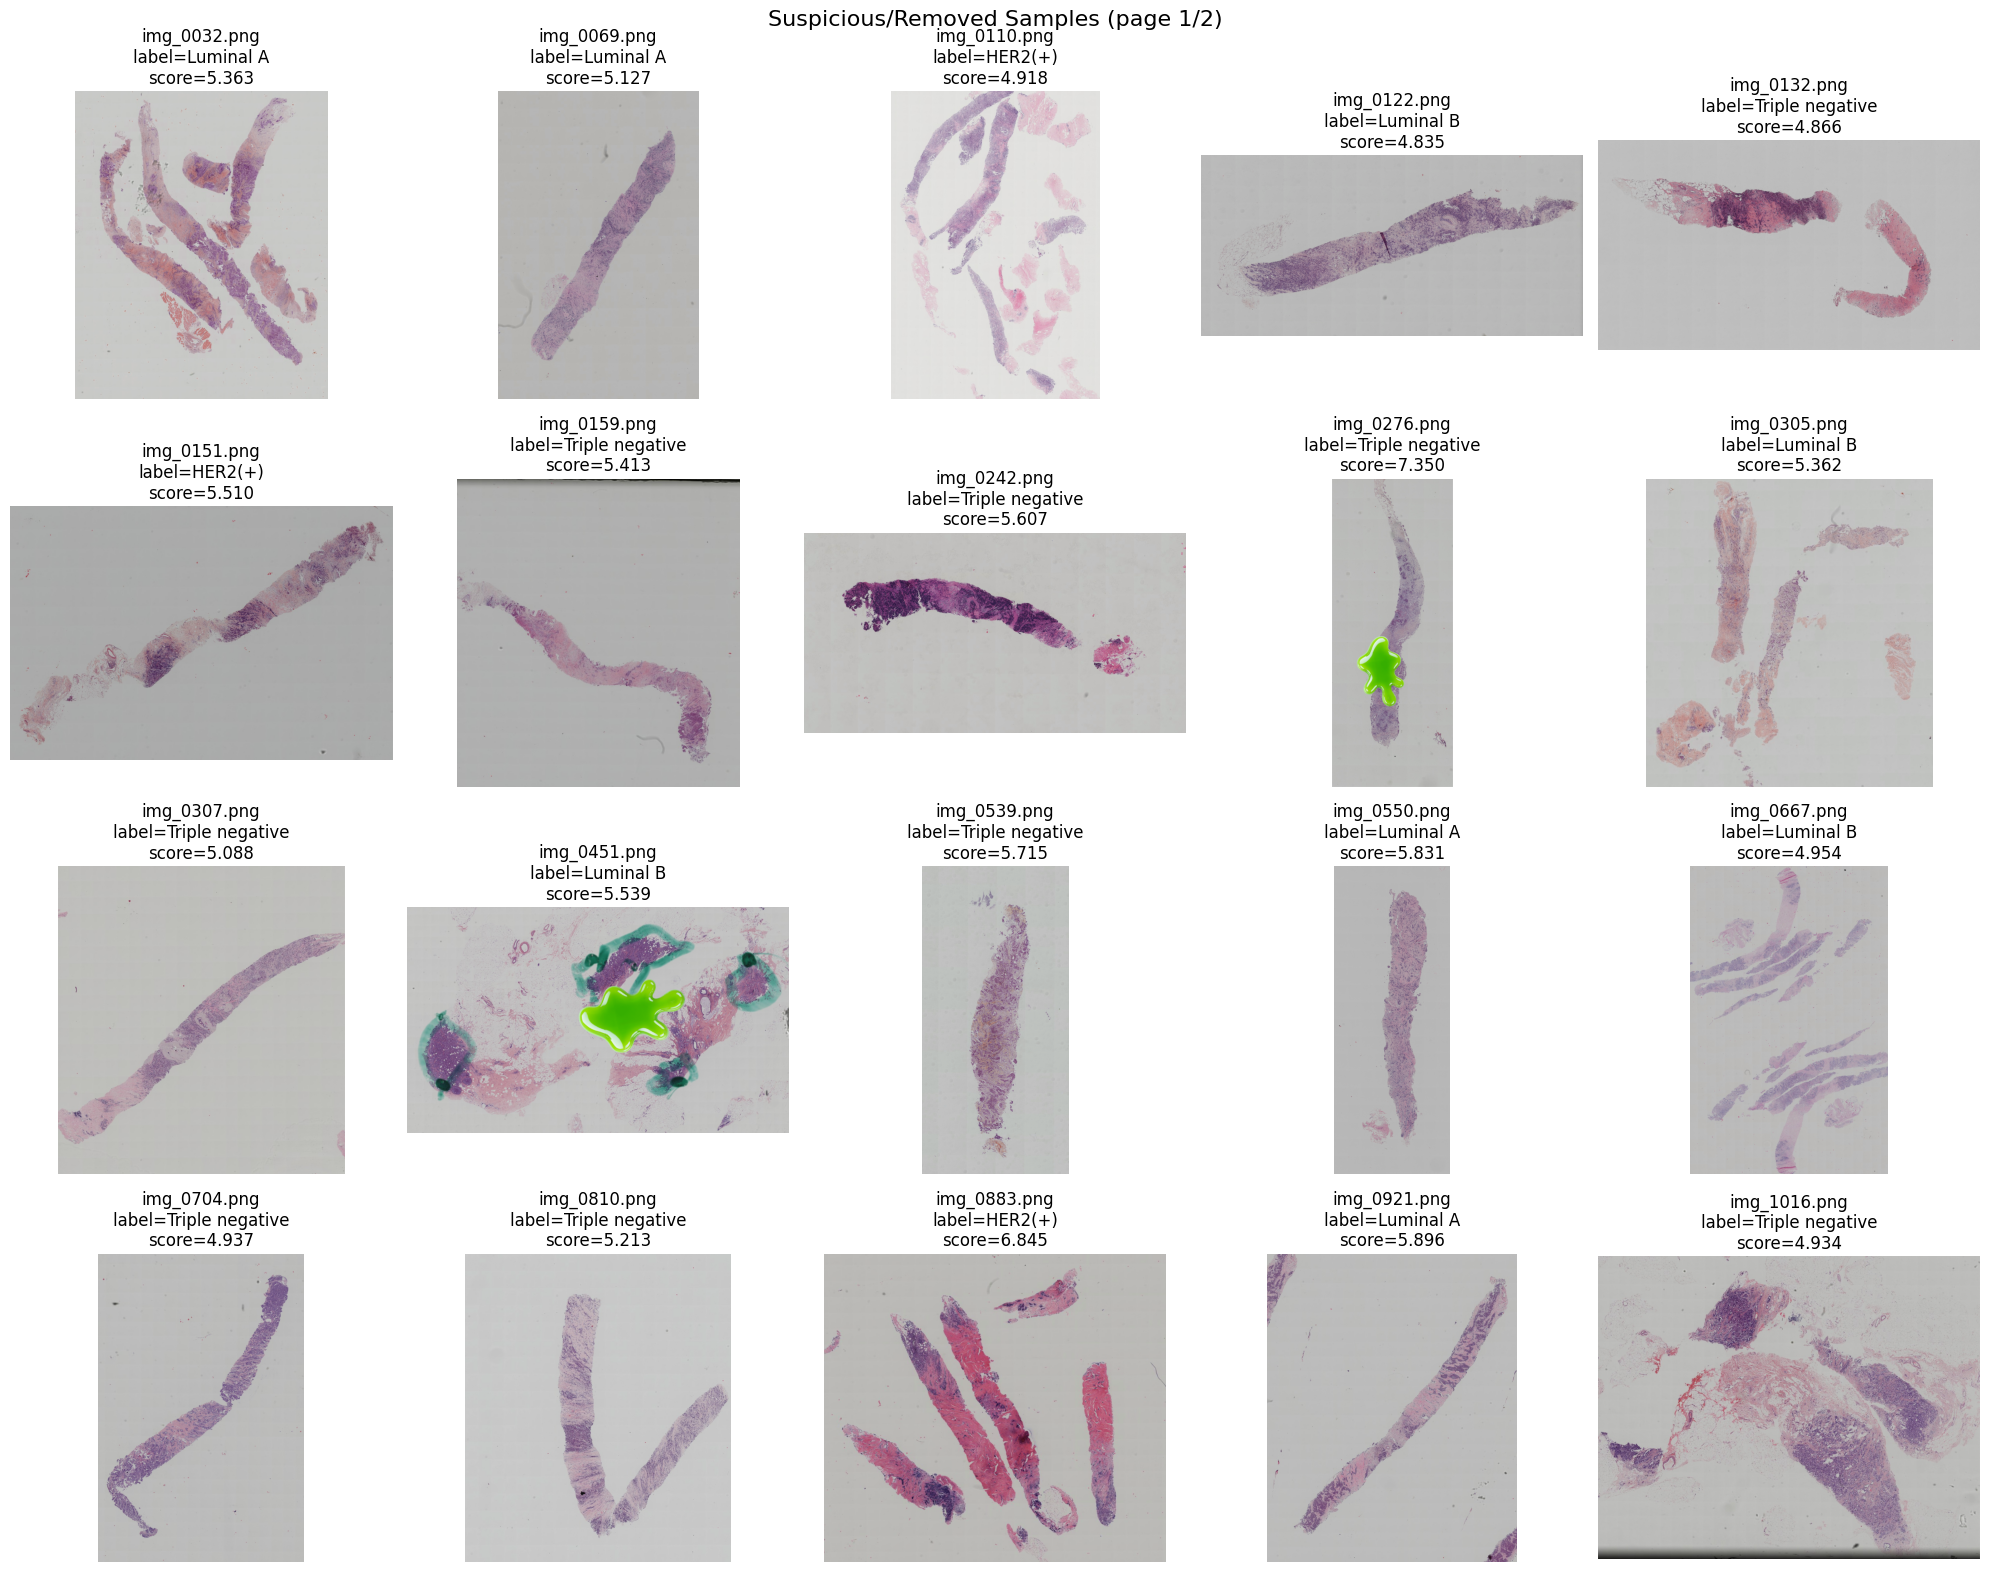

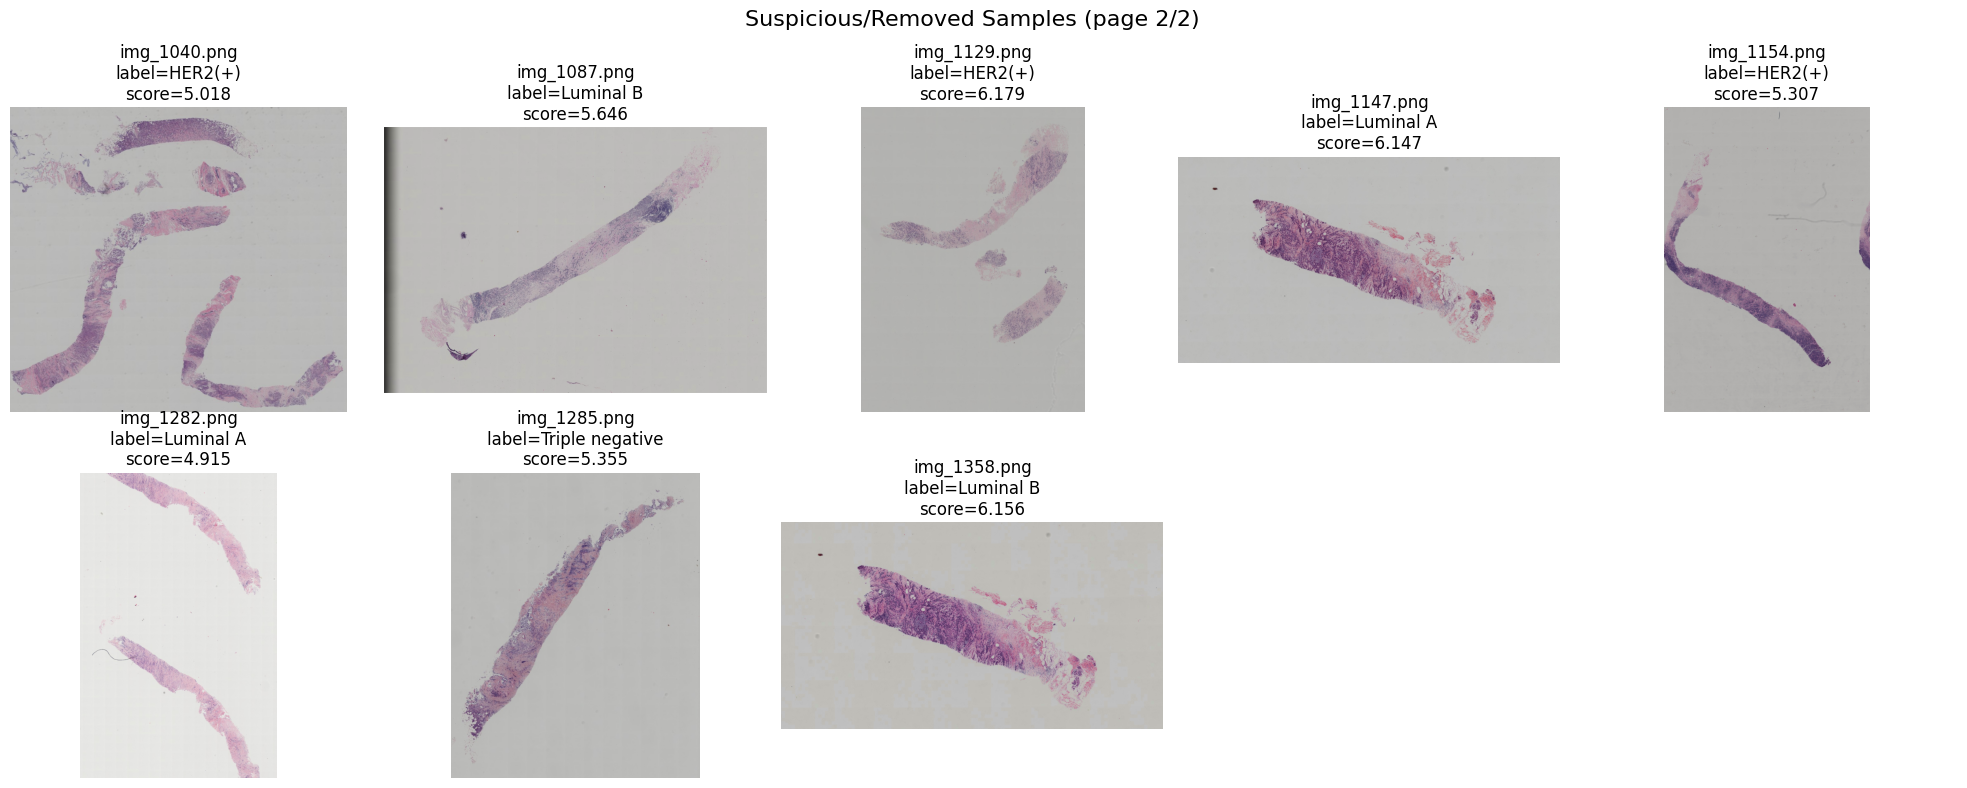

In [13]:
# Cell: Visualize all removed (suspicious) samples

# This assumes df_train_merged and TRAIN_IMG_DIR are already defined above.

if "df_train_merged" not in globals():
    print("df_train_merged is not available. Run the previous cells first.")
else:
    df_removed = df_train_merged[df_train_merged["is_suspicious"]].copy()
    print(f"Total removed (suspicious) samples: {len(df_removed)}")

    if len(df_removed) == 0:
        print("No suspicious samples to display.")
    else:
        # Plot in pages of N images per figure to avoid huge grids
        N_PER_PAGE = 20
        N_COLS = 5
        n_pages = int(np.ceil(len(df_removed) / N_PER_PAGE))

        for page in range(n_pages):
            start = page * N_PER_PAGE
            end = min((page + 1) * N_PER_PAGE, len(df_removed))
            subset = df_removed.iloc[start:end]

            n_imgs = len(subset)
            n_rows = int(np.ceil(n_imgs / N_COLS))

            fig, axes = plt.subplots(n_rows, N_COLS, figsize=(4 * N_COLS, 4 * n_rows))
            axes = np.array(axes).reshape(-1)

            for ax, (_, row) in zip(axes, subset.iterrows()):
                sample_index = row["sample_index"]
                img_path = os.path.join(TRAIN_IMG_DIR, sample_index)
                if not os.path.exists(img_path):
                    ax.set_title(f"Missing: {sample_index}")
                    ax.axis("off")
                    continue
                img = Image.open(img_path).convert("RGB")
                ax.imshow(img)
                title = f"{sample_index}\nlabel={row['label']}\nscore={row['difficulty_score']:.3f}"
                ax.set_title(title)
                ax.axis("off")

            # Hide any unused axes
            for i in range(n_imgs, len(axes)):
                axes[i].axis("off")

            plt.suptitle(f"Suspicious/Removed Samples (page {page+1}/{n_pages})", fontsize=16)
            plt.tight_layout()
            plt.show()